# Colour Correction using Splines

### Define constants

In [28]:
%load_ext autoreload
%autoreload 2
import colour
from data import load_dataset_sfu, load_dataset_csv, load_illuminant_cmfs, load_camera
import numpy as np

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

SFU_FILE_PATH = 'reflect_db.reflect'
CAVE_FOSTER2004_PATH = 'cave_foster2004.csv'
FOSTER_50_PATH = 'foster50.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
sfu_dataset = load_dataset_sfu(SFU_FILE_PATH)
cave_foster2004_dataset = load_dataset_csv(CAVE_FOSTER2004_PATH)
foster_50_dataset = load_dataset_csv(FOSTER_50_PATH)

TRAIN = cave_foster2004_dataset
TEST = foster_50_dataset
VALIDATION = sfu_dataset
CAMERA = 'sigma'

### Spectral sensitivities of various cameras

In [30]:

MSDS_TRAIN, SDS_TRAIN = load_camera(CAMERA)


1939.82119587


### Computing Observer Responses
We can easily change the order of test and train sets here

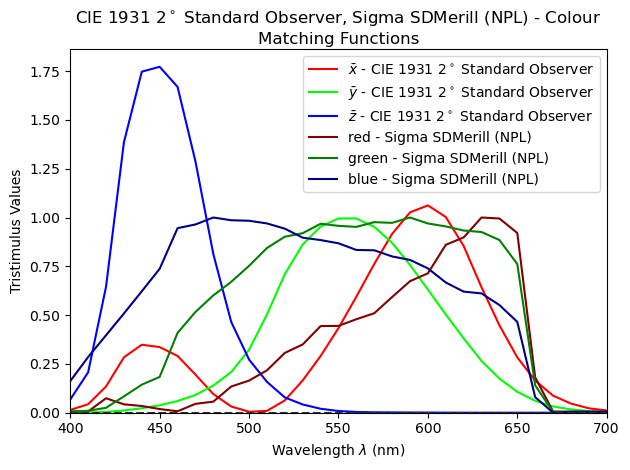

In [31]:
illuminant, cmfs = load_illuminant_cmfs()
colour.plotting.plot_multi_cmfs([MSDS_TRAIN, cmfs])
response_trainset_xyz = colour.characterisation.training_data_sds_to_XYZ(TRAIN, cmfs, illuminant)
response_testset_xyz = colour.characterisation.training_data_sds_to_XYZ(TEST, cmfs, illuminant)
response_validation_xyz = colour.characterisation.training_data_sds_to_XYZ(VALIDATION, cmfs, illuminant)

### Computing Camera Responses

In [32]:
response_trainset_camera, _ = colour.characterisation.training_data_sds_to_RGB(TRAIN, MSDS_TRAIN, SDS_TRAIN)
response_testset_camera, _ = colour.characterisation.training_data_sds_to_RGB(TEST, MSDS_TRAIN, SDS_TRAIN)
response_validationset_camera,  _ = colour.characterisation.training_data_sds_to_RGB(VALIDATION, MSDS_TRAIN, SDS_TRAIN)

print(np.max(response_trainset_camera))
print(np.max(response_testset_camera))
print(np.max(response_validationset_camera))

0.958464477666
0.954189469601
0.870478908159


In [33]:
response_trainset_camera_augmented = np.vstack((response_trainset_camera, response_trainset_camera / 2))
response_trainset_xyz_augmented = np.vstack((response_trainset_xyz, response_trainset_xyz / 2))


### Fit Generalized Additive Model with P-splines

In [34]:
from sklearn.metrics import make_scorer
from colour_math import deltae_mean
from models import GAMOptimizer
from evaluate import pred
from skopt import BayesSearchCV

np.int = np.int64
custom_scorer = make_scorer(deltae_mean, greater_is_better=False)

param_grid_gam = {
    'lams': [1*10**(-i) for i in range(2, 10)],
}
print(param_grid_gam)
gam = GAMOptimizer(lams=0.0001,order=3, n_splines=20)

bayes_search = BayesSearchCV(
    gam,
    param_grid_gam,
    n_iter=50,  # Number of iterations for the Bayesian optimization
    cv=5,
    n_jobs=-1,
    scoring=custom_scorer,
    verbose=2,
    random_state=RANDOM_STATE,  # Set a random seed for reproducibility
)
bayes_search.fit(response_trainset_camera, response_trainset_xyz)

print("Best parameters:", bayes_search.best_params_)



pred(bayes_search, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")

{'lams': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


3600
3600
[CV] END .........................................lams=1e-05; total time= 1.1min
3600
[CV] END .........................................lams=1e-05; total time= 1.1min
[CV] END .........................................lams=1e-05; total time= 1.1min
3600
3600
[CV] END .........................................lams=1e-05; total time= 1.1min
[CV] END .........................................lams=1e-05; total time= 1.1min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
3600
[CV] END .........................................lams=1e-07; total time= 1.1min
3600
3600
[CV] END .........................................lams=1e-07; total time= 1.1min
[CV] END .........................................lams=1e-07; total time= 1.1min
3600
3600
[CV] END .........................................lams=1e-07; total time= 1.1min
[CV] END .........................................lams=1e-07; total time= 1.1min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
3600
3600
[CV] END ...